In [3]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math
import scipy
from tqdm.notebook import tqdm

In [84]:
pcd = o3d.io.read_point_cloud("models/Carola.ply")
o3d.visualization.draw_geometries([pcd])

In [73]:
np.asarray(pcd.points[5000: 5010])

array([[ 0.58325648, -8.3922863 ,  3.3641181 ],
       [-0.26547742, -8.55193806,  3.67780542],
       [ 0.75686646, -8.16636086,  3.36230254],
       [ 0.77507436, -8.1403513 ,  3.39328265],
       [ 0.76654267, -8.16069794,  3.36726594],
       [-0.28504497, -8.4440136 ,  3.71138024],
       [-0.37742364, -8.43933201,  3.67859793],
       [ 0.58494782, -8.39383793,  3.36148787],
       [-0.38121963, -8.41050529,  3.69697046],
       [-0.25907677, -8.56754684,  3.69704413]])

In [85]:
pcd = pcd.voxel_down_sample(voxel_size=0.05)
point_cloud_in_numpy = np.asarray(pcd.points)

In [86]:
point_cloud_in_numpy

array([[ 0.66777837,  2.76816273,  1.7045387 ],
       [ 0.67913417,  2.94775915,  1.8034205 ],
       [ 1.472417  ,  2.73928595,  1.05046499],
       ...,
       [ 0.03705714,  3.53597238,  3.58337423],
       [-0.60988016,  4.67695176,  0.92950135],
       [-0.04206671,  9.88686371,  0.42606627]])

# NDT

In [87]:
s = 0.3
te = 0.04
A = point_cloud_in_numpy // s

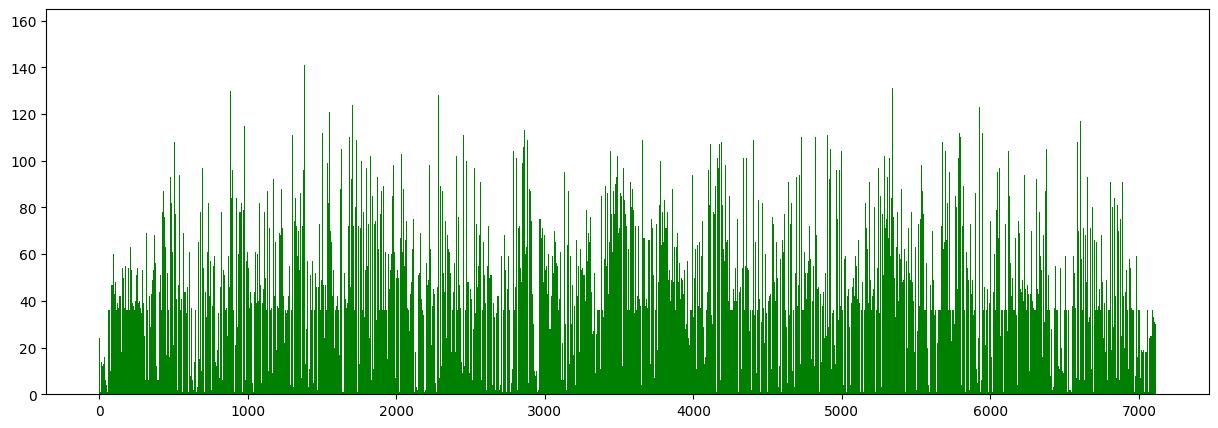

In [88]:
unique,counts=np.unique(A,axis=0, return_counts=True)
plt.figure(figsize=(15,5))
plt.bar(range(0, len(counts)), counts, width=1.5, color='g')
plt.show()

In [89]:
def IRLS_find_norm(points, cov):
    lambd, e = np.linalg.eig(cov)
    e = e.T
    o = lambd.argsort()
    lambd = lambd[o]
    e = e[o]
    gamma = 1e-6
    k_w = 2.985
    n = e[0]
    g = np.mean(points, axis = 0)
    X_prev = np.zeros(3)
    for i in range(100):
        n_old = n
        r = (points - g) @ n
        w = np.exp(-(r ** 2 / k_w ** 2))
        X_k = np.average(points - g - X_prev, axis=0, weights=w)
        vec = (points - g - X_k)
        X_prev = X_k
        C = (vec.T * w) @ vec
        w, v = np.linalg.eig(C)
        v = v.T
        o = w.argsort()
        w = w[o]
        v = v[o]
        n = v[0]
        convg = np.linalg.norm(n_old - n) / np.linalg.norm(n_old)
        if convg < gamma:
            break
    return n

In [90]:
mu = []
normals = []
Q = []
Q_points = []
P = []
for ind, i in tqdm(list(enumerate(unique))):
    this_cell = np.array(point_cloud_in_numpy[np.where(np.prod(A == i, axis = -1))])
    if len(this_cell) <= 3:
        P.append(this_cell)
        continue
    mu.append(np.mean(this_cell))
    cov = np.cov(np.array(this_cell).T)
    #print("cov = ", cov)
    w, v = np.linalg.eig(cov)
    v = v.T
    o = w.argsort()
    w = w[o]
    v = v[o]
    #print("values = ", w)
    if abs(w[0] / w[1]) <= te:
        Q.append(i)
        Q_points.append(this_cell)
        normals.append(IRLS_find_norm(this_cell, cov))
    else:
        P.append(this_cell)
P = np.concatenate(P)

  0%|          | 0/7114 [00:00<?, ?it/s]

In [79]:
len(Q)

894

In [91]:
Q_indices = {}
for index, cell_index in enumerate(Q):
    Q_indices[tuple(cell_index)] = index

In [92]:
# Q_points = np.array(Q_points)
normals = np.array(normals)
print(Q[0])
print(np.shape(normals), len(Q_points))

[ -8. -31.   0.]
(3016, 3) 3016


In [13]:
def create_circle_mesh(center, normal, radius, num_points=12):
    mesh = o3d.geometry.TriangleMesh()
    x_axis = np.array([1, 0, 0])
    if np.abs(normal.dot(x_axis)) < 0.1:
        x_axis = np.array([0, 1, 0])
    u = np.cross(normal, x_axis)
    u = u / np.linalg.norm(u)
    v = np.cross(normal, u)
    v = v / np.linalg.norm(v)

    # Generate points on a circle in 2D coordinates
    angles = np.linspace(0, 2*np.pi, num_points+1)[:-1]
    points_2d = radius * np.column_stack((np.cos(angles), np.sin(angles)))

    # Convert points to 3D coordinates
    circle_points = [center + points_2d[i,0]*u + points_2d[i,1]*v for i in range(num_points)]

    mesh.vertices = o3d.utility.Vector3dVector(circle_points)
    mesh.vertices.append(center)

    # Add faces connecting center to circle points
    for i in range(num_points):
        face = [i, (i+1) % num_points, num_points]
        mesh.triangles.append(face)
        face = [(i+1) % num_points, i, num_points]
        mesh.triangles.append(face)


    mesh.compute_vertex_normals()
    return mesh

In [93]:
color = [1.0, 0.5, 0.0] # orange color
threshold = 0.4
radius = s / 3
neighbors = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]


In [94]:
meshes = []
for i in range(len(Q_points)):
    center = np.mean(Q_points[i], axis=0)
    normal = normals[i]
    mesh = create_circle_mesh(center, normal, radius, num_points=12)
    mesh.paint_uniform_color(color)
    meshes.append(mesh)

o3d.visualization.draw_geometries(meshes)

In [95]:
meshes = []
for i in range(len(Q_points)):
    center = np.mean(Q_points[i], axis=0)
    normal = normals[i]

    for neigh_move in neighbors:
        neigh_cell_index = tuple((center // s) + neigh_move)
        if neigh_cell_index not in Q_indices:
            continue

        index = Q_indices[neigh_cell_index]
        neighbor, neighbor_normal = np.mean(Q_points[index], axis=0), normals[index]
        angle = np.arccos(np.dot(normal, neighbor_normal))
        if angle < threshold:
            line_set = o3d.geometry.LineSet()
            line_set.points = o3d.utility.Vector3dVector([center, neighbor])
            line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
            line_set.colors = o3d.utility.Vector3dVector([color])
            meshes.append(line_set)

# meshes.append(pcd)
o3d.visualization.draw_geometries(meshes)

# RANSAC

In [48]:
def plane(Q, P, Q_points, normals):
    k_max = 50
    nu = 0.95
    delta_d = 0.08
    n = 0
    delta_theta = 0.25
    k = 0
    Psi = np.zeros(len(Q), dtype=bool)
    Psi_size = 0
    Psi_points = []
    k = 1
    while k < k_max:
        c = np.random.choice(range(0, len(Q)))
        cell = Q[c]
        points = Q_points[c]
        gk = np.mean(points, axis=0)
        nk = normals[c]
        Ik = np.zeros(len(Q), dtype=bool)
        cnt = 0
        Ik_points = []
        for i, v in enumerate(Q):
            g_i = np.mean(Q_points[i], axis=0)
            n_i = normals[i]
            d_i = np.dot((g_i - gk), nk) / np.linalg.norm(nk)
            theta_i = 1 - np.abs(np.dot(nk, n_i)) / (np.linalg.norm(nk) * np.linalg.norm(n_i))
            if np.abs(d_i) < delta_d and theta_i < delta_theta:
                Ik[i] = True
                cnt += 1
                Ik_points += Q_points[i]
        if cnt > Psi_size:
            Psi = Ik
            Psi_points = Ik_points
            Psi_size = cnt
            n = nk
            g = gk
            Pn = Psi_size / len(Q)
            k_max = int(np.ceil(np.log(1 - nu) / np.log(1 - Pn)))
        k += 1

    P_mask = np.zeros(len(P), dtype=bool)
    for j, i in enumerate(P):
        d_i = np.inner(i - g, n) / np.linalg.norm(n)
        if (np.abs(d_i) < delta_d):
            P_mask[j] = True
            Psi_points.append(i)
    return n, g, np.array(Psi_points), Q[~Psi], Q_points[~Psi], P[~P_mask], normals[~Psi]
